# matching

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load datasets
# treatment_metrics = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-[6months-before-after-hn].csv")
treatment_metrics = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-cumulative.csv", encoding="utf-7")
treatment_metadata = pd.read_csv("../dataset/hn-stories-gh-ai-metadata.csv")
# control_metrics = pd.read_csv("../dataset/nonhn-gh-ai-metrics-[2147].csv", encoding="utf-7")
control_metrics = pd.read_csv("../dataset/nonhn-gh-ai-metrics-cumulative.csv", encoding="utf-7")
control_metadata = pd.read_csv("../dataset/nonhn-gh-ai-metadata-[2147].csv")

# Convert date columns
treatment_metrics['month'] = pd.to_datetime(treatment_metrics['month']).dt.tz_localize('UTC')
treatment_metadata['repo_creation_date'] = pd.to_datetime(treatment_metadata['repo_creation_date']).dt.tz_convert('UTC')
control_metrics['month'] = pd.to_datetime(control_metrics['month']).dt.tz_localize('UTC')
control_metadata['repo_creation_date'] = pd.to_datetime(control_metadata['repo_creation_date']).dt.tz_convert('UTC')

# Metrics to match
# metrics = ['new_forks', 'new_stars', 'new_commits', 'new_prs', 'active_contributors']
metrics = ['cumulative_stars', 'cumulative_forks', 'cumulative_commits', 'cumulative_prs', 'cumulative_ve_contributors']

# Earliest available metrics date (May 2022)
earliest_metrics_date = pd.Timestamp('2022-05-01', tz='UTC')

# Function to find best control match
def find_best_match(treatment_row, metric):
    """Finds the best matching control repository based on the specified metric over available months."""
    hn_submission_date = pd.to_datetime(treatment_row['hn_submission_date']).tz_localize('UTC')
    treatment_repo = treatment_row['repo_full_name']
    treatment_repo_url = treatment_row['repo_url']

    # Get treatment repo creation date
    treatment_creation_date = treatment_metadata[treatment_metadata['repo_full_name'] == treatment_repo]['repo_creation_date'].values
    if len(treatment_creation_date) == 0:
        return None  # Skip if metadata is missing
    treatment_creation_date = pd.to_datetime(treatment_creation_date[0])

    # Define 6-month period before submission (or use available data if cut off)
    start_date = max(earliest_metrics_date, hn_submission_date - pd.DateOffset(months=6))
    end_date = hn_submission_date - pd.DateOffset(months=1)

    # Filter treatment data for available months
    treatment_subset = treatment_metrics[
        (treatment_metrics['repo_full_name'] == treatment_repo) &
        (treatment_metrics['month'] >= start_date) &
        (treatment_metrics['month'] <= end_date)
    ]

    if treatment_subset.empty:
        return None

    # Determine how many months are available
    num_available_months = treatment_subset['month'].nunique()

    # Get treatment metric values as a vector
    treatment_values = treatment_subset[metric].values.reshape(1, -1)

    # Find control repos created before start_date
    valid_controls = control_metadata[control_metadata['repo_creation_date'] <= start_date]
    valid_control_names = set(valid_controls['repo_full_name'])

    # Filter control repos with valid metrics
    control_subset = control_metrics[
        (control_metrics['control_repo'].isin(valid_control_names)) &
        (control_metrics['month'] >= start_date) &
        (control_metrics['month'] <= end_date)
    ]

    if control_subset.empty:
        return None

    # Reshape control data into time-series format (only for available months)
    control_time_series = control_subset.pivot(index='month', columns='control_repo', values=metric).fillna(0)

    # Keep only control repos with at least the same number of months as treatment repo
    valid_control_repos = control_time_series.columns[control_time_series.count(axis=0) >= num_available_months]
    control_time_series = control_time_series[valid_control_repos]

    if control_time_series.shape[1] == 0:
        return None

    # Compute cosine similarity
    control_vectors = control_time_series.T.values  # Convert to array (each row = available-month vector)

    # Inside find_best_match function, replace the similarity calculation and selection
    similarities = cosine_similarity(treatment_values, control_vectors)[0]
    euclidean_dists = euclidean_distances(treatment_values, control_vectors)[0]

    # Define thresholds (adjust these values based on your data)
    cosine_threshold = 0.7  # Higher is better for cosine
    euclidean_threshold = 50.0  # Lower is better for euclidean

    # Find candidates that meet both criteria
    valid_matches = []
    for i in range(len(similarities)):
        if similarities[i] >= cosine_threshold and euclidean_dists[i] <= euclidean_threshold:
            valid_matches.append((i, similarities[i], euclidean_dists[i]))

    if not valid_matches:
        return None  # Skip if no matches meet both thresholds

    # Sort by cosine similarity (descending) as primary criterion
    valid_matches.sort(key=lambda x: x[1], reverse=True)
    best_idx = valid_matches[0][0]

    # Continue with existing code to get best match details
    best_match_repo = control_time_series.columns[best_idx]
    best_match_metadata = control_metadata[control_metadata['repo_full_name'] == best_match_repo].iloc[0]

    # Include both similarity scores in the result
    return [
        treatment_repo, treatment_repo_url, hn_submission_date,
        treatment_creation_date, treatment_values.sum(), treatment_row['new_forks'],
        best_match_repo, best_match_metadata['repo_creation_date'],
        control_time_series.iloc[:, best_idx].sum(), best_match_metadata['fork_count'],
        similarities[best_idx], euclidean_dists[best_idx], 1  # Added euclidean distance
    ]

# Process each metric separately
for metric in metrics:
    print(f"\nProcessing metric: {metric}")
    results = []

    for _, treatment_row in tqdm(
        treatment_metrics.drop_duplicates(subset=['repo_full_name']).iterrows(),
        total=treatment_metrics['repo_full_name'].nunique(),
        desc=f"Matching {metric}"
    ):
        match = find_best_match(treatment_row, metric)
        if match:
            results.append(match)

    # Save results
    if results:
        df_results = pd.DataFrame(results, columns=[
            "treatment_repo", "treatment_repo_url", "hn_submission_date",
            "treatment_creation_date", f"treatment_{metric}", "treatment_forks",
            "control_repo", "control_creation_date", f"control_{metric}", "control_forks",
            "similarity_score", "euclidean_distance", "ranking"
        ])
        df_results.to_csv(f"matched_control_{metric}.csv", index=False)
    else:
        print(f"No matches found for {metric}.")



Processing metric: cumulative_stars


Matching cumulative_stars: 100%|██████████| 163/163 [00:02<00:00, 60.29it/s]



Processing metric: cumulative_forks


Matching cumulative_forks: 100%|██████████| 163/163 [00:02<00:00, 60.55it/s]



Processing metric: cumulative_commits


Matching cumulative_commits: 100%|██████████| 163/163 [00:02<00:00, 61.28it/s]



Processing metric: cumulative_prs


Matching cumulative_prs: 100%|██████████| 163/163 [00:02<00:00, 61.83it/s]



Processing metric: cumulative_ve_contributors


Matching cumulative_ve_contributors: 100%|██████████| 163/163 [00:02<00:00, 58.32it/s]


# visualizing parallel trend

C:\Users\prach\AppData\Local\Temp\ipykernel_15616\2828127839.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


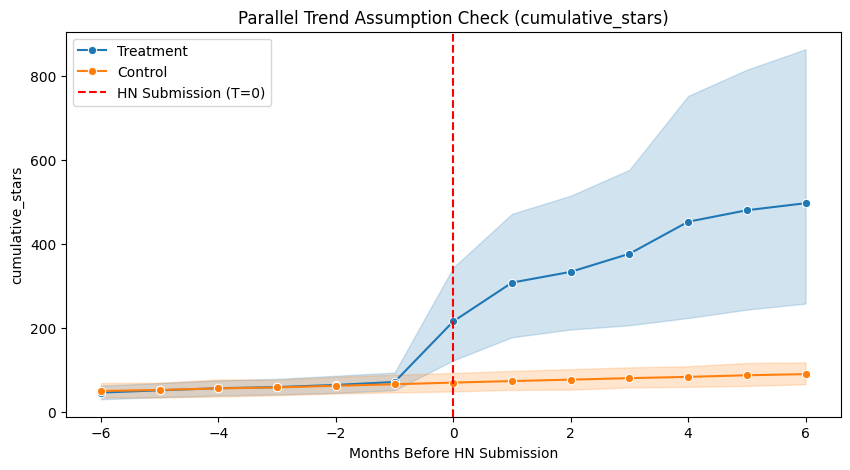

C:\Users\prach\AppData\Local\Temp\ipykernel_15616\2828127839.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


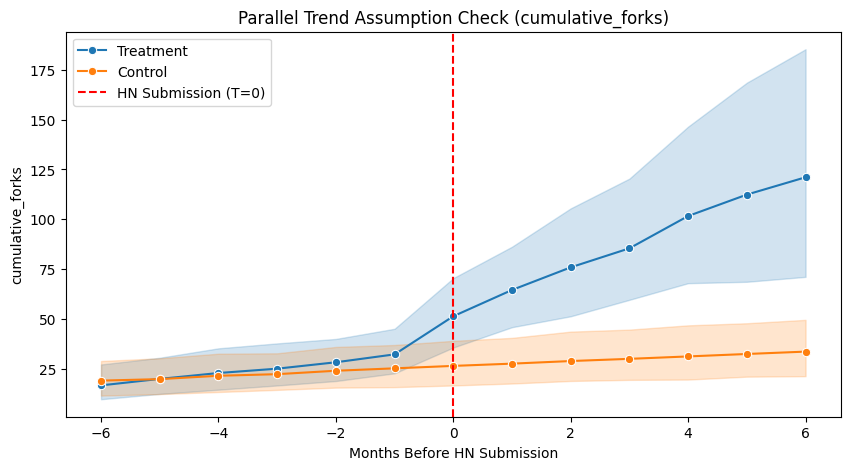

C:\Users\prach\AppData\Local\Temp\ipykernel_15616\2828127839.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


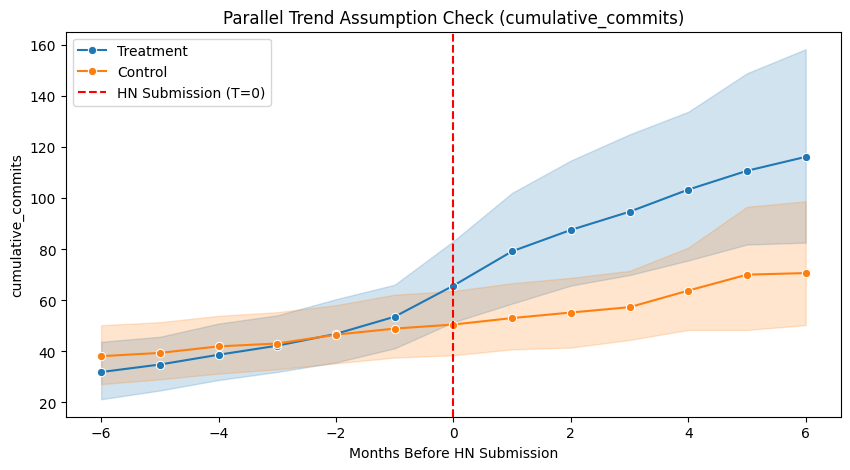

C:\Users\prach\AppData\Local\Temp\ipykernel_15616\2828127839.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


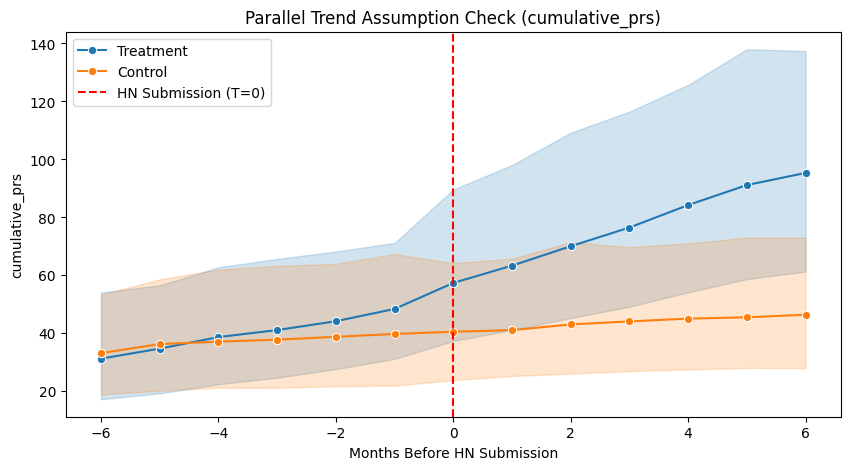

C:\Users\prach\AppData\Local\Temp\ipykernel_15616\2828127839.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


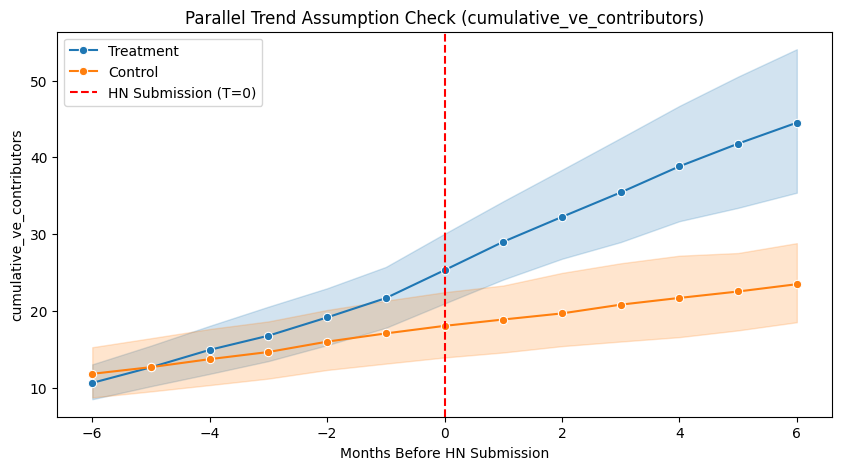

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# metrics = ['new_stars', 'new_forks', 'new_commits', 'new_prs', 'active_contributors']
metrics = ['cumulative_stars', 'cumulative_forks', 'cumulative_commits', 'cumulative_prs', 'cumulative_ve_contributors']

# Align time: Convert dates to relative months
def align_time(df, hn_date):
    hn_date = hn_date.tz_localize(None)  # Remove timezone
    df['relative_month'] = df['month'].dt.to_period("M").apply(lambda x: (x - hn_date.to_period("M")).n)
    return df

# Aggregate trends: Average over all repos
def plot_aggregate_trend(metric):
    plt.figure(figsize=(10, 5))

    sns.lineplot(
        data=df_aligned,
        x="relative_month",
        y=metric,
        hue="repo_type",
        ci=95,  # Confidence interval
        marker="o"
    )

    plt.axvline(x=0, color='red', linestyle='dashed', label="HN Submission (T=0)")
    plt.xlabel("Months Before HN Submission")
    plt.ylabel(metric)
    plt.title(f"Parallel Trend Assumption Check ({metric})")
    plt.legend()
    plt.show()

# Load the original metric data
df_treatment = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-cumulative.csv", encoding="utf-7")
df_control = pd.read_csv("../dataset/nonhn-gh-ai-metrics-cumulative.csv", encoding="utf-7")
# df_treatment = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-[6months-before-after-hn].csv")
# df_control = pd.read_csv("../dataset/nonhn-gh-ai-metrics-[2147].csv", encoding="utf-7")

for metric in metrics:
    # Load matched treatment-control data
    df_matched = pd.read_csv(f"./matched_control_{metric}.csv")  # Adjust filename as needed

    # Convert date columns
    df_treatment['month'] = pd.to_datetime(df_treatment['month'])
    df_control['month'] = pd.to_datetime(df_control['month'])
    df_matched['hn_submission_date'] = pd.to_datetime(df_matched['hn_submission_date'])

    # Store aligned trends for aggregation
    aligned_treatment = []
    aligned_control = []

    # Iterate through matched pairs
    for _, row in df_matched.iterrows():
        treatment_repo = row['treatment_repo']
        control_repo = row['control_repo']
        hn_date = row['hn_submission_date']

        # Align treatment repo data
        treatment_data = df_treatment[df_treatment['repo_full_name'] == treatment_repo].copy()
        treatment_data = align_time(treatment_data, hn_date)
        treatment_data['repo_type'] = 'Treatment'
        aligned_treatment.append(treatment_data)

        # Align control repo data
        control_data = df_control[df_control['control_repo'] == control_repo].copy()
        control_data = align_time(control_data, hn_date)
        control_data['repo_type'] = 'Control'
        aligned_control.append(control_data)

    # Combine aligned data
    df_aligned = pd.concat(aligned_treatment + aligned_control, ignore_index=True)

    # Ensure relative_month is an integer for filtering
    df_aligned['relative_month'] = df_aligned['relative_month'].astype(int)

    # Filter for pre-submission period (T = -6 to -1)
    df_aligned = df_aligned[(df_aligned['relative_month'] >= -6) & (df_aligned['relative_month'] <= 6)]

    plot_aggregate_trend(metric)


In [10]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats

# Load datasets
df_treatment = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-cumulative.csv", encoding="utf-7")
df_control = pd.read_csv("../dataset/nonhn-gh-ai-metrics-cumulative.csv", encoding="utf-7")
# df_treatment = pd.read_csv("../dataset/hn-stories-gh-ai-metrics-[6months-before-after-hn].csv")
# df_control = pd.read_csv("../dataset/nonhn-gh-ai-metrics-[2147].csv", encoding="utf-7")

# Convert date columns
df_treatment['month'] = pd.to_datetime(df_treatment['month'])
df_control['month'] = pd.to_datetime(df_control['month'])

# List of metrics to analyze
metrics = ['cumulative_stars', 'cumulative_forks', 'cumulative_commits', 'cumulative_prs', 'cumulative_ve_contributors']
# metrics = ['new_stars', 'new_forks', 'new_commits', 'new_prs', 'active_contributors']


# Function to align time with HN submission date
def align_time(df, hn_date):
    hn_date = hn_date.tz_localize(None)
    df = df.copy()
    df['relative_month'] = df['month'].dt.to_period("M").apply(lambda x: (x - hn_date.to_period("M")).n)
    return df

# Store results
trend_results = []
balancing_results = []

# Iterate through metrics
for metric in metrics:
    # Load matched treatment-control data
    df_matched = pd.read_csv(f"./matched_control_{metric}.csv")

    aligned_treatment, aligned_control = [], []

    # Iterate through matched pairs
    for _, row in df_matched.iterrows():
        treatment_repo = row['treatment_repo']
        control_repo = row['control_repo']
        hn_date = pd.to_datetime(row['hn_submission_date'])

        # Align treatment repo data
        treatment_data = df_treatment[df_treatment['repo_full_name'] == treatment_repo].copy()
        treatment_data = align_time(treatment_data, hn_date)
        treatment_data['repo_type'] = 'Treatment'
        aligned_treatment.append(treatment_data)

        # Align control repo data
        control_data = df_control[df_control['control_repo'] == control_repo].copy()
        control_data = align_time(control_data, hn_date)
        control_data['repo_type'] = 'Control'
        aligned_control.append(control_data)

    # Combine data
    df_aligned = pd.concat(aligned_treatment + aligned_control, ignore_index=True)
    df_aligned['relative_month'] = df_aligned['relative_month'].astype(int)

    # Filter for pre-submission period (-6 to -1)
    df_pre_treatment = df_aligned.loc[(df_aligned['relative_month'] >= -6) & (df_aligned['relative_month'] <= -1)].copy()
    df_pre_treatment.loc[:, 'time'] = df_pre_treatment['relative_month']  # Fix warning

    # --- Group-Specific Linear Trends ---
    for group in ['Treatment', 'Control']:
        df_group = df_pre_treatment[df_pre_treatment['repo_type'] == group]
        X = sm.add_constant(df_group['time'])
        y = df_group[metric]

        model = sm.OLS(y, X).fit()
        trend_results.append({'Metric': metric, 'Group': group, 'Slope': model.params['time']})

    # --- Balancing Test ---
    treatment_vals = df_pre_treatment[df_pre_treatment['repo_type'] == 'Treatment'][metric]
    control_vals = df_pre_treatment[df_pre_treatment['repo_type'] == 'Control'][metric]

    t_stat, p_value = stats.ttest_ind(treatment_vals, control_vals, equal_var=False)  # Welch’s t-test
    balancing_results.append({'Metric': metric, 'p-value': p_value})

# Convert results to DataFrames for better formatting
df_trends = pd.DataFrame(trend_results)
df_balancing = pd.DataFrame(balancing_results)

# Output results
print("\nGroup-Specific Linear Trends (Pre-Treatment Slopes):")
print(df_trends.to_string(index=False))

print("\nBalancing Test p-values:")
print(df_balancing.to_string(index=False))



Group-Specific Linear Trends (Pre-Treatment Slopes):
                    Metric     Group    Slope
          cumulative_stars Treatment 4.775324
          cumulative_stars   Control 3.223959
          cumulative_forks Treatment 2.999517
          cumulative_forks   Control 1.264049
        cumulative_commits Treatment 4.242312
        cumulative_commits   Control 2.195023
            cumulative_prs Treatment 3.328746
            cumulative_prs   Control 1.175855
cumulative_ve_contributors Treatment 2.187205
cumulative_ve_contributors   Control 1.063482

Balancing Test p-values:
                    Metric  p-value
          cumulative_stars 0.895989
          cumulative_forks 0.447202
        cumulative_commits 0.649349
            cumulative_prs 0.675732
cumulative_ve_contributors 0.111872
